## Variables
id

cnae3: spanish cnae code

dcna3_agr3: spanish cnae code description

provincia: pronvince 

anio: founding year of the company

gradvinc: linkage with the bank (the least, the better)

nopotra: nº of services with the bank 

noprovin: nº of products with the bank

volneg: business volumen with the bank

fact: Amount of money the cards emitted by the bank spent in the POS owned by the company

num_bancos: numero de bancos con lo que tiene contratado POS

pmc: avg collection period

target: 1 (sucess) | 0

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

### df_train Preprocessing

In [2]:
train_df = pd.read_csv('20240108_train.txt', sep=';')
train_df['provincia'] = train_df['provincia'].replace('**', np.nan)
train_df['provincia'] = train_df['provincia'].astype('Int64')
train_df = train_df.drop(['dcnae_agr3'], axis=1)
print(train_df.shape, "\n")
print(train_df.dtypes)
train_df.head()

(24921, 12) 

id              int64
cnae3           int64
provincia       Int64
anio          float64
gradvinc        int64
noprotra        int64
noprovin        int64
volneg        float64
fact          float64
num_bancos    float64
pmc           float64
target          int64
dtype: object


,id,cnae3,provincia,anio,gradvinc,noprotra,noprovin,volneg,fact,num_bancos,pmc,target
0,616016,432,28,2016.0,1,4,4,86062.25,NaN,NaN,NaN,1
1,243724,411,28,1992.0,5,0,0,0.00,NaN,NaN,NaN,0
2,637325,960,33,2018.0,5,0,0,0.00,NaN,NaN,NaN,0
3,385667,432,35,2004.0,1,4,4,174966.92,NaN,NaN,NaN,0
4,605174,466,50,2013.0,5,0,0,0.00,NaN,NaN,75.73,0


In [3]:
train_df.describe()

,id,cnae3,provincia,anio,gradvinc,noprotra,noprovin,volneg,fact,num_bancos,pmc,target
count,24921.00000,24921.000000,24714.0,24813.000000,24921.000000,24921.000000,24921.000000,2.492100e+04,3.614000e+03,3614.000000,9.095000e+03,24921.000000
mean,453976.78476,513.057141,25.362467,2002.456374,3.515228,1.349986,0.802054,8.805150e+04,2.605555e+04,1.919480,5.489077e+03,0.121905
std,261479.13431,216.376012,13.890656,11.482027,1.614522,1.623209,1.497464,6.482998e+05,9.288299e+04,1.632561,4.630098e+05,0.327183
min,29.00000,9.000000,0.0,1896.000000,1.000000,0.000000,0.000000,-1.266810e+05,0.000000e+00,1.000000,0.000000e+00,0.000000
25%,227368.00000,431.000000,12.0,1996.000000,2.000000,0.000000,0.000000,0.000000e+00,1.709832e+03,1.000000,1.489500e+01,0.000000
50%,454349.00000,475.000000,28.0,2003.000000,4.000000,1.000000,0.000000,2.392600e+02,6.789140e+03,1.000000,5.284000e+01,0.000000
75%,688863.00000,682.000000,36.0,2011.000000,5.000000,3.000000,1.000000,3.112389e+04,2.158924e+04,2.000000,1.096550e+02,0.000000
max,880947.00000,990.000000,52.0,2024.000000,5.000000,8.000000,13.000000,5.204917e+07,2.599505e+06,13.000000,4.412950e+07,1.000000


In [4]:
train_df.nunique()

id            24921
cnae3           255
provincia        53
anio            104
gradvinc          4
noprotra          9
noprovin         14
volneg        13816
fact           3607
num_bancos       11
pmc            6710
target            2
dtype: int64

In [5]:
train_df.isna().sum()

id                0
cnae3             0
provincia       207
anio            108
gradvinc          0
noprotra          0
noprovin          0
volneg            0
fact          21307
num_bancos    21307
pmc           15826
target            0
dtype: int64

In [9]:
non_informed_variables = train_df.columns.values[train_df.apply(lambda x: 100*np.sum(x.isna())/len(x)) >= 50].tolist()
train_df = train_df.drop(non_informed_variables, axis = 1)

train_df['provincia'] = train_df['provincia'].fillna(0)

mediana_anio = train_df['anio'].median()
train_df['anio'] = train_df['anio'].fillna(mediana_anio)

C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

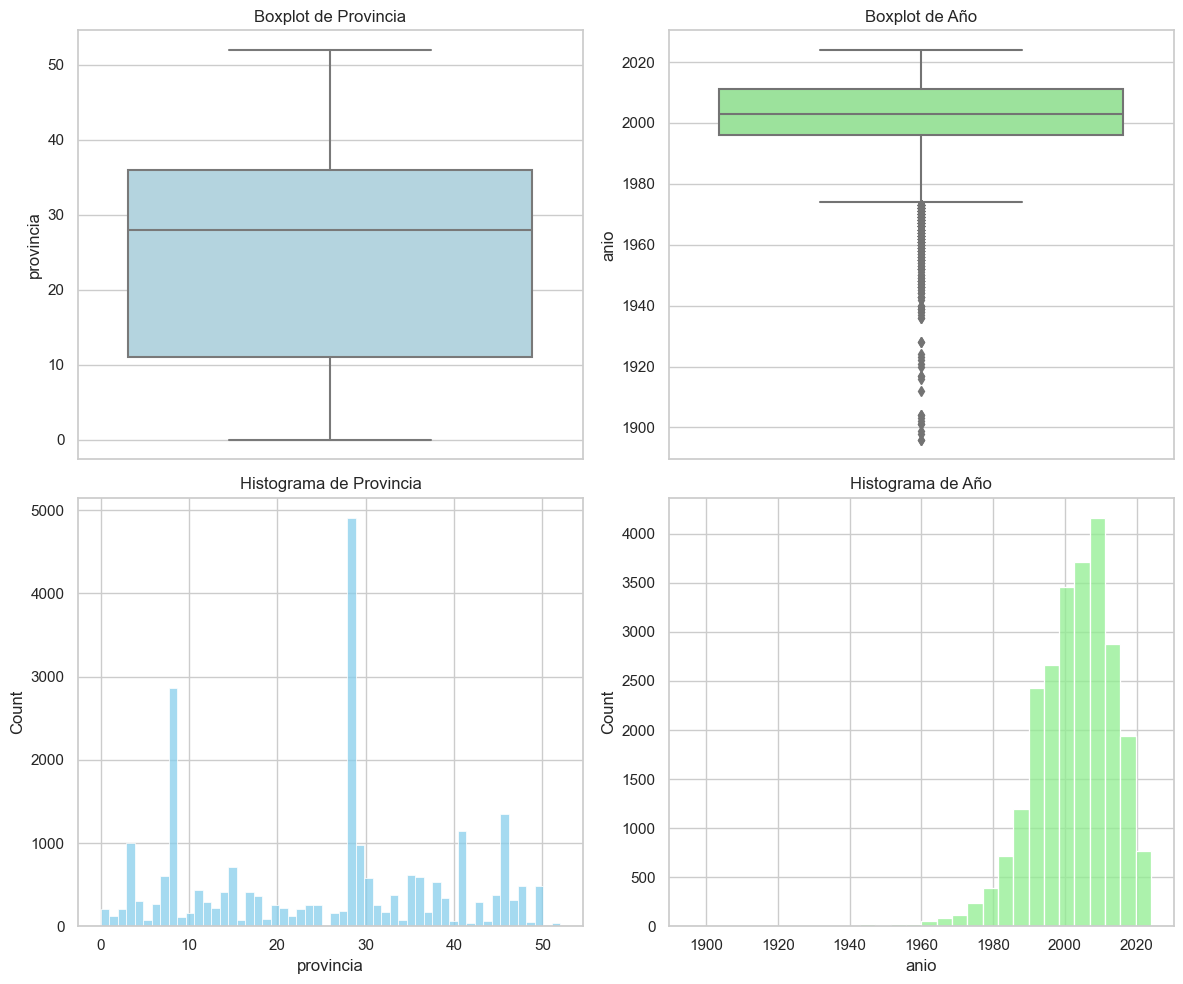

In [10]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=train_df, y="provincia", ax=axs[0, 0], color='lightblue').set_title("Boxplot de Provincia")
sns.histplot(data=train_df, x="provincia", ax=axs[1, 0], kde=False, bins=54, color='skyblue').set_title("Histograma de Provincia")
sns.boxplot(data=train_df, y="anio", ax=axs[0, 1], color='lightgreen').set_title("Boxplot de Año")
sns.histplot(data=train_df, x="anio", ax=axs[1, 1], kde=False, bins=30, color='lightgreen').set_title("Histograma de Año")

plt.tight_layout()
plt.show()

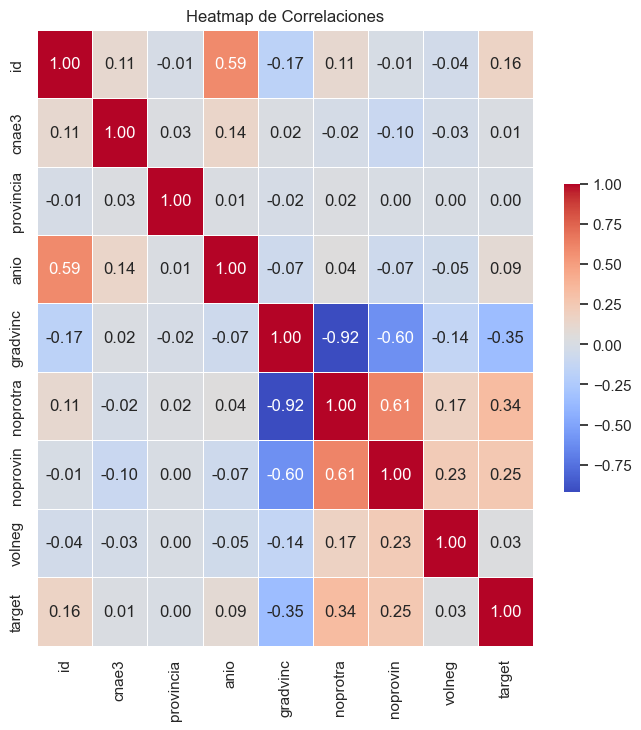

In [8]:
corr_matrix = train_df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap de Correlaciones')

plt.show()

In [11]:
# Feature engineering
train_df['ratio'] = (train_df['noprotra'] + train_df['noprovin']) / train_df['gradvinc']

train_df['volneg_sign'] = np.sign(train_df['volneg'])

In [12]:
train_df = train_df.drop(['anio', 'volneg'], axis=1)

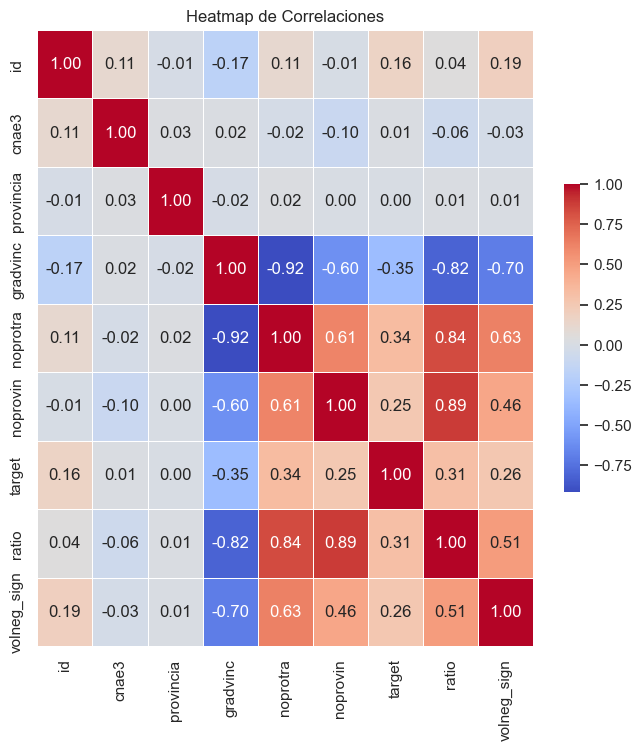

In [13]:
corr_matrix = train_df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap de Correlaciones')

plt.show()

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop='if_binary')
encoded_data = encoder.fit_transform(train_df[['provincia', 'cnae3']])
columns = encoder.get_feature_names_out(['provincia', 'cnae3'])
df_encoded_sklearn = pd.DataFrame(encoded_data, columns=columns)
train_df = pd.concat([train_df.drop(['provincia', 'cnae3'], axis=1), df_encoded_sklearn], axis=1)

train_df

C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,gradvinc,noprotra,noprovin,target,ratio,volneg_sign,provincia_0.0,provincia_1.0,provincia_2.0,...,cnae3_920,cnae3_931,cnae3_932,cnae3_941,cnae3_949,cnae3_951,cnae3_952,cnae3_960,cnae3_970,cnae3_990
0,616016,1,4,4,1,8.00,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,243724,5,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,637325,5,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,385667,1,4,4,0,8.00,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,605174,5,0,0,0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24916,742492,4,1,2,0,0.75,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24917,617487,1,3,4,0,7.00,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24918,486289,5,0,0,0,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24919,405081,4,1,0,0,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preparacion df_test

In [15]:
test_df = pd.read_csv('20240108_test_no_target.txt', sep=';')
test_df['provincia'] = test_df['provincia'].replace('**', np.nan)
test_df['provincia'] = test_df['provincia'].astype('Int64')
test_df = test_df.drop(['dcnae_agr3'], axis=1)

print(test_df.shape, "\n")
print(test_df.dtypes)
test_df.head()

(2852, 11) 

id              int64
cnae3           int64
provincia       Int64
anio          float64
gradvinc        int64
noprotra        int64
noprovin        int64
volneg        float64
fact          float64
num_bancos    float64
pmc           float64
dtype: object


,id,cnae3,provincia,anio,gradvinc,noprotra,noprovin,volneg,fact,num_bancos,pmc
0,458072,474,8,2007.0,5,0,0,0.00,NaN,NaN,NaN
1,516331,412,28,1998.0,5,0,0,0.00,NaN,NaN,NaN
2,3424,681,8,1996.0,1,3,3,601225.40,NaN,NaN,NaN
3,880645,452,30,2015.0,5,0,0,0.00,NaN,NaN,NaN
4,31272,465,28,1978.0,4,1,4,115845.06,10479.74,3.0,68.85


In [17]:
non_informed_variables = test_df.columns.values[test_df.apply(lambda x: 100*np.sum(x.isna())/len(x)) >= 50].tolist()
test_df = test_df.drop(non_informed_variables, axis = 1)

test_df['provincia'] = test_df['provincia'].fillna(0)

mediana_anio = test_df['anio'].median()
test_df['anio'] = test_df['anio'].fillna(mediana_anio)

In [18]:
test_df.isna().sum()

id           0
cnae3        0
provincia    0
anio         0
gradvinc     0
noprotra     0
noprovin     0
volneg       0
dtype: int64

In [19]:
test_df['ratio'] = (test_df['noprotra'] + test_df['noprovin']) / test_df['gradvinc']

test_df['volneg_sign'] = np.sign(test_df['volneg'])

In [20]:
test_df = test_df.drop(['anio', 'volneg'], axis=1)

In [21]:
encoder = OneHotEncoder(sparse=False, drop='if_binary')

encoded_data = encoder.fit_transform(test_df[['provincia', 'cnae3']])

columns = encoder.get_feature_names_out(['provincia', 'cnae3'])

df_encoded_sklearn = pd.DataFrame(encoded_data, columns=columns)

test_df = pd.concat([test_df.drop(['provincia', 'cnae3'], axis=1), df_encoded_sklearn], axis=1)

C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
test_df

,id,gradvinc,noprotra,noprovin,ratio,volneg_sign,provincia_0.0,provincia_1.0,provincia_2.0,provincia_3.0,...,cnae3_900,cnae3_910,cnae3_920,cnae3_931,cnae3_932,cnae3_941,cnae3_949,cnae3_951,cnae3_952,cnae3_960
0,458072,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,516331,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3424,1,3,3,6.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,880645,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31272,4,1,4,1.25,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,458428,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2848,192154,4,1,1,0.50,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2849,213202,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2850,776938,5,0,0,0.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print(train_df.shape)
print(test_df.shape)

(24921, 315)
(2852, 264)


In [24]:
columns_to_add = [col for col in train_df.columns if col not in test_df.columns]

for column in columns_to_add:
    test_df[column] = 0.0

test_df = test_df[train_df.columns]

In [25]:
test_df = test_df.drop(['target'], axis=1)

In [26]:
print(train_df.shape)
print(test_df.shape)

(24921, 315)
(2852, 314)


### Modelo

In [27]:
X = train_df.drop(['target'],axis=1)
y = train_df[['target', 'id']]
X = X.set_index('id')
y = y.set_index('id')

In [28]:
X_test_final = test_df.set_index('id')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=9999, 
                                                    stratify=y)

In [30]:
X_train

,gradvinc,noprotra,noprovin,ratio,volneg_sign,provincia_0.0,provincia_1.0,provincia_2.0,provincia_3.0,provincia_4.0,...,cnae3_920,cnae3_931,cnae3_932,cnae3_941,cnae3_949,cnae3_951,cnae3_952,cnae3_960,cnae3_970,cnae3_990
id,,,,,,,,,,,,,,,,,,,,,
336484,1,4,5,9.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
503147,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169306,5,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113840,2,6,1,3.50,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155607,5,0,0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868659,2,3,0,1.50,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395755,1,2,1,3.00,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836460,4,1,1,0.50,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
y_train.head()

,target
id,
336484,0
503147,0
169306,0
113840,0
155607,0


### Grid Search

In [32]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer, f1_score
# from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

# # Suponemos que X_train, y_train están previamente definidos

# # Define la métrica personalizada
# def custom_metric(y_true, y_pred):
#     return f1_score(y_true, y_pred, average="binary")

# scorer = make_scorer(custom_metric, greater_is_better=True)

# # Definir la pipeline incluyendo SMOTE, SelectKBest y XGBClassifier
# model_pipeline = ImbPipeline(steps=[
#     ('smote', SMOTE(sampling_strategy=0.7, random_state=42)),
#     ('feature_selection', SelectKBest(score_func=f_classif, k=60)),
#     ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
# ])

# # Definir la distribución de parámetros para RandomizedSearchCV
# # Asegúrate de ajustar los nombres de parámetros para que coincidan con los de la pipeline
# param_distributions = {
#     'classifier__n_estimators': [100, 101, 102, 103],
#     'classifier__learning_rate': [0.3, 0.5],
#     'classifier__gamma': [0.1],
#     'classifier__max_depth': [3, 4, 5, 6],
#     'classifier__min_child_weight': [18, 20, 22],
#     'classifier__subsample': [0.5]
# }

# # Configurar RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=model_pipeline,
#     param_distributions=param_distributions,
#     n_iter=60,
#     scoring=scorer,
#     cv=10,  # Ajustado para este ejemplo, pero puede ser modificado según tus necesidades
#     verbose=1,
#     random_state=0,
#     refit=True,
#     n_jobs=-1
# )

# # Ajustar el modelo
# random_search.fit(X_train, y_train['target'])  # Asegúrate de que y_train está correctamente definido

# # # Mejores parámetros encontrados
# # print("Mejores parámetros:", random_search.best_params_)

# # # Mejor puntuación encontrada
# # print("Mejor puntuación:", random_search.best_score_)

In [33]:
# best_xgb = random_search.best_params_
# best_xgb

In [34]:
# results = random_search.cv_results_
# results = pd.DataFrame(results)
# results.T

### Random Forest

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

def custom_metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average="binary")

best_params_model = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.7, random_state=50)),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),
    ('classifier', XGBClassifier(
        n_estimators=102,
        learning_rate=0.3,
        gamma=0.5,
        max_depth=5,
        min_child_weight=25,
        subsample=0.5,
        random_state=4,
        use_label_encoder=False,
        eval_metric='logloss'))
])

best_params_model.fit(X_train, y_train['target'])

C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 71 110 206 281] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('smote', SMOTE(random_state=50, sampling_strategy=0.7)),
                ('feature_selection', SelectKBest(k=100)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types...a=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=25, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=102, n_jobs=None,
                               num_parallel_tree=None, random_state=4, ...))])

In [33]:
from sklearn.metrics import f1_score

y_pred = best_params_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary')  

metrics_result = {
    "Model Accuracy": round(accuracy, 3),
    "Confusion Matrix": conf_matrix,  
    "Precision": round(precision, 3),
    "Recall": round(recall, 3),
    "F1 Score": round(f1, 3)
}

metrics_result

{'Model Accuracy': 0.868,
 'Confusion Matrix': array([[5995,  571],
        [ 418,  493]], dtype=int64),
 'Precision': 0.463,
 'Recall': 0.541,
 'F1 Score': 0.499}

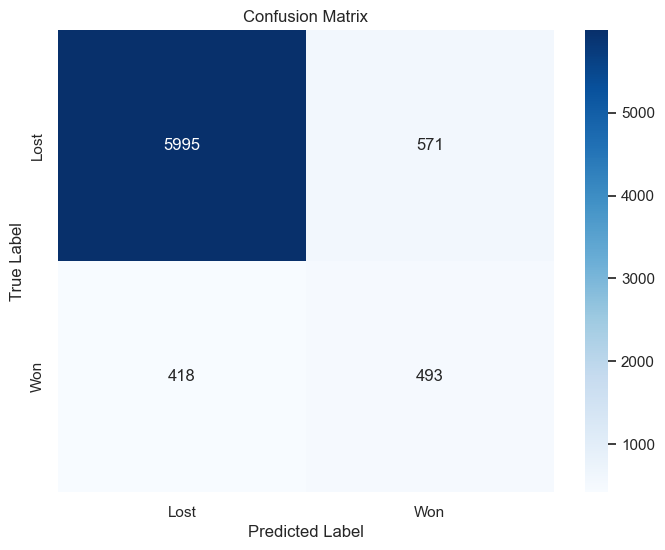

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Lost', 'Won'], yticklabels=['Lost', 'Won'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

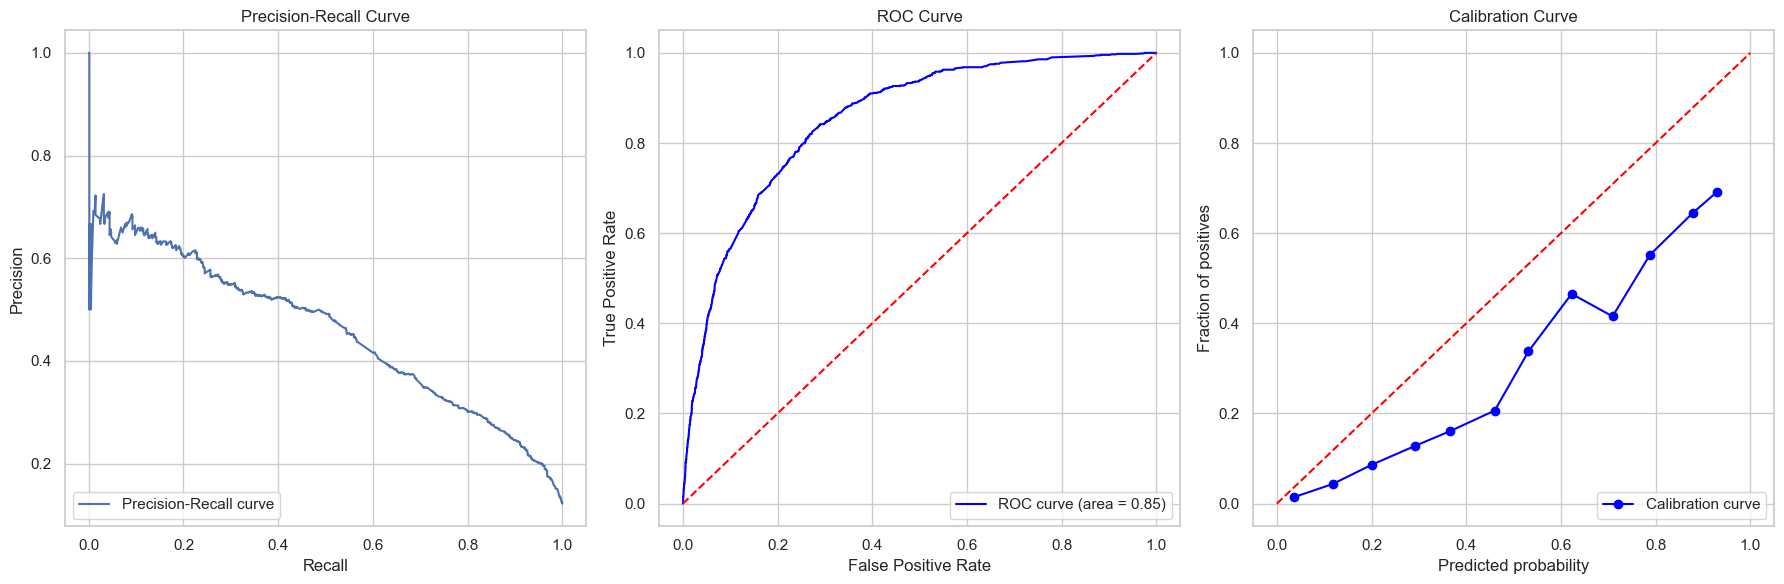

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

sns.set(style="whitegrid")

y_proba = best_params_model.predict_proba(X_test)[:, 1] 

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=12, strategy='uniform')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Precision-Recall
ax[0].plot(recall, precision, label='Precision-Recall curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve')
ax[0].legend(loc="lower left")

# ROC
ax[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='red', linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

# Calibration Curve
ax[2].plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration curve')
ax[2].plot([0, 1], [0, 1], color='red', linestyle='--')
ax[2].set_xlabel('Predicted probability')
ax[2].set_ylabel('Fraction of positives')
ax[2].set_title('Calibration Curve')
ax[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lggas\anaconda3\envs\ie\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


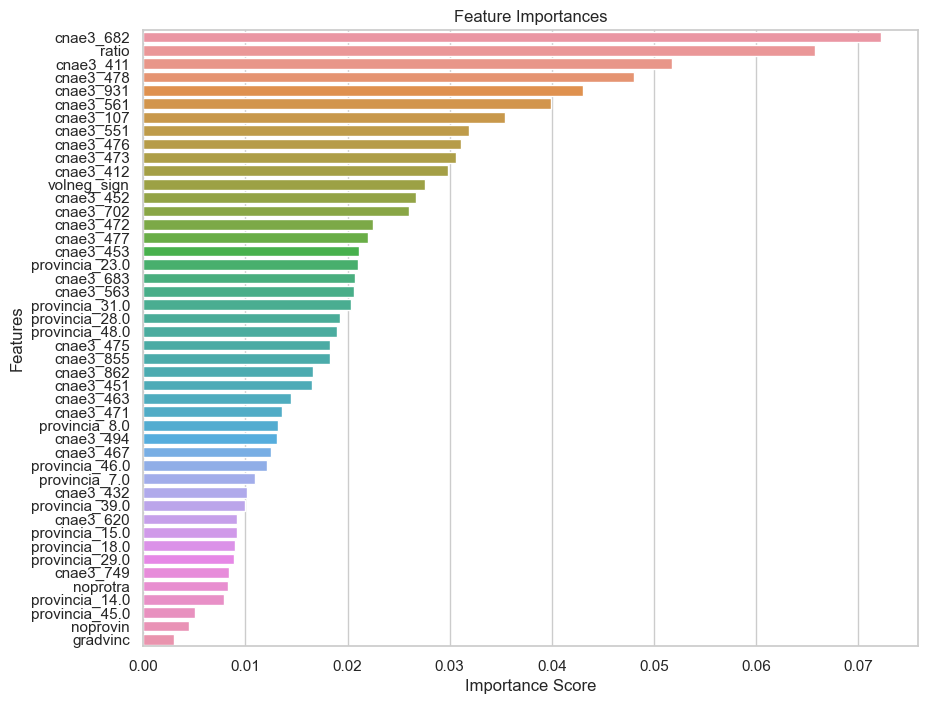

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

xgb_classifier = best_params_model.named_steps['classifier']
feature_importances = xgb_classifier.feature_importances_

selected_features_mask = best_params_model.named_steps['feature_selection'].get_support()
selected_feature_names = X_train.columns[selected_features_mask]

features_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_n = 46
top_features_df = features_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features_df)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

### Resultado final

In [37]:
y_pred_final = best_params_model.predict(X_test_final)

predictions_df = pd.DataFrame(y_pred_final, index=X_test_final.index, columns=['Prediction'])

print(predictions_df['Prediction'].value_counts())

predictions_df.head()

Prediction
0    2445
1     407
Name: count, dtype: int64


,Prediction
id,
458072,0
516331,0
3424,0
880645,0
31272,0


In [38]:
predictions_df.to_csv('predictions_df.txt', sep=';', index=True, header=False)

In [39]:
predictions_df['Prediction'].value_counts()

Prediction
0    2445
1     407
Name: count, dtype: int64